## Homework №2

### Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
import string
import numpy as np

In [ ]:
try:
    with open('../../datasets/Shakespeare_sonnets/sonnets.txt', 'r') as iofile:
        text = iofile.readlines()
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt -nc
    with open('sonnets.txt', 'r') as iofile:
        text = iofile.readlines()

File ‘sonnets.txt’ already there; not retrieving.



In [ ]:
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
text2 = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In [ ]:
text[::200]

['  From fairest creatures we desire increase,\n',
 "    And nothing 'gainst Time's scythe can make defence\n",
 '  Now see what good turns eyes for eyes have done:\n',
 '  In our two loves there is but one respect,\n',
 '  How careful was I when I took my way,\n',
 '    To subjects worse have given admiring praise.\n',
 '  When I perhaps compounded am with clay,\n',
 '  That you yourself, being extant, well might show\n',
 '  Which, like a canker in the fragrant rose,\n',
 '    Have eyes to wonder, but lack tongues to praise.\n',
 "  The ills that were not, grew to faults assur'd,\n",
 '  Than in the breath that from my mistress reeks.\n',
 '  O! but with mine compare thou thine own state,\n',
 '  CLIV\n']

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text)
text = text.lower()
text2 = [el.lower() for el in text2]

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
# dict <index>:<char>
# Your great code here
token_to_idx = {index:char for index, char in enumerate(tokens)}

# dict <char>:<index>
# Your great code 
idx_to_token = {char:index for index, char in enumerate(tokens)}

In [ ]:
' '.join(idx_to_token)

"\n   ! ' ( ) , - . : ; ? a b c d e f g h i j k l m n o p q r s t u v w x y z"

In [ ]:
text2[::2000]

['  despite of wrinkles this thy golden time.\n',
 "  not by our feeling, but by others' seeing:\n"]

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [ ]:
def ohe(num):
  c = np.zeros(38)
  c[num] = 1
  return c

def to_matrix(text2, max_len=None, pad=idx_to_token[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, text2))
    text2_ix_ohe = np.zeros([len(text2), max_len, 38], dtype)
    text2_ix = np.zeros([len(text2), max_len], dtype) + pad
    # print (text2_ix.shape)

    for i in range(len(text2)):
        line_ix_ohe = [ohe(idx_to_token[c]) for c in text2[i]]
        # print (line_ix)
        text2_ix_ohe[i, :len(line_ix_ohe)] = line_ix_ohe

        line_ix = [idx_to_token[c] for c in text2[i]]
        text2_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        text2_ix_ohe = np.transpose(text2_ix_ohe)
        text2_ix = np.transpose(text2_ix)
    
    return text2_ix_ohe, text2_ix

# def to_matrix(text2, max_len=None, pad=idx_to_token[' '], dtype='int32', batch_first = True):
#     """Casts a list of names into rnn-digestable matrix"""
    
#     max_len = max_len or max(map(len, text2))
#     text2_ix = np.zeros([len(text2), max_len], dtype) + pad

#     for i in range(len(text2)):
#         line_ix = [idx_to_token[c] for c in text2[i]]
#         text2_ix[i, :len(line_ix)] = line_ix
        
#     if not batch_first: # convert [batch, time] into [time, batch]
#         text2_ix = np.transpose(text2_ix)

#     return text2_ix

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CharRNNCell(nn.Module):

    def __init__(self, num_tokens=len(tokens), embedding_size=128, rnn_num_units=256):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        # self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(num_tokens + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):

        # x_emb = self.embedding(torch.LongTensor(x))
        x_emb = torch.tensor(x).float()
        x_and_h = torch.cat([x_emb, h_prev], dim=1) # YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) # YOUR CODE HERE
        h_next = torch.tanh(h_next) # YOUR CODE HERE
        assert h_next.size() == h_prev.size()
        logits = self.rnn_to_logits(h_next)# YOUR CODE
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):

        return torch.zeros(batch_size, self.num_units, requires_grad=True).float()

char_rnn = CharRNNCell()
criterion = nn.NLLLoss() # YOUR CODE HERE

In [ ]:
def rnn_loop(char_rnn, batch_ix):

    batch_size, max_length, _ = batch_ix.shape
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(1,0,2):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
    return torch.stack(logprobs, dim=1)

In [ ]:
# batch_ix, _ = to_matrix([' hello']) # (1, 6, 38)
# b0 = torch.tensor(batch_ix.transpose(1,0,2)[0]).float() # (1, 38)
# h_prev = torch.zeros(1, 256, requires_grad=True).float()

# x_and_h = torch.cat([b0, h_prev], dim=1) # [1, 294]
# rnn_update = nn.Linear(294, 256)
# rnn_to_logits = nn.Linear(256, 38)

# h_next = rnn_update(x_and_h) # [1, 256]
# h_next = torch.tanh(h_next)
# logits = rnn_to_logits(h_next) # [1, 38]
# logits.shape
# f = F.log_softmax(logits, -1) # [5, 38]

In [ ]:
batch_ix_ohe, batch_ix = to_matrix(text2[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix_ohe)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix_ohe.shape

In [ ]:
predictions_logp = logp_seq[:, :-1]
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
actual_next_tokens = batch_ix[:, 1:]

loss = criterion(predictions_logp.contiguous().view(-1, 38), 
                  actual_next_tokens.contiguous().view(-1))

loss.backward()

for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


tensor(3.6263, grad_fn=<NllLossBackward>)

In [ ]:
from IPython.display import clear_output
from random import sample
import matplotlib.pyplot as plt

char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

Plot the loss function (axis X: number of epochs, axis Y: loss function).

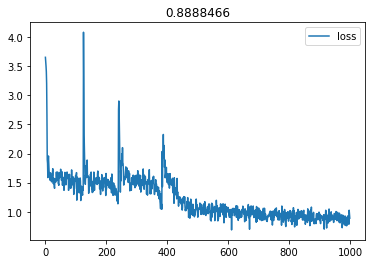

In [ ]:
MAX_LENGTH = 100
num_tokens = 38

for i in range(1000):
    batch_ix_ohe, batch_ix = to_matrix(sample(text2, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix_ohe)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]# YOUR CODE HERE
    actual_next_tokens = batch_ix[:, 1:]# YOUR CODE HERE

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    ) # YOUR CODE HERE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    # YOUR CODE HERE
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.title(loss.data.numpy())
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [ ]:
char_rnn

CharRNNCell(
  (rnn_update): Linear(in_features=294, out_features=256, bias=True)
  (rnn_to_logits): Linear(in_features=256, out_features=38, bias=True)
)

In [ ]:
def generate_sample(char_rnn, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):

    # x_sequence = [idx_to_token[token] for token in seed_phrase]
    # x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    x_sequence_ohe, x_sequence = to_matrix([seed_phrase])
    x_sequence = torch.tensor(x_sequence, dtype=torch.int64)
    # print (x_sequence.shape)
    hid_state = char_rnn.initial_state(batch_size=1)
    # print (hid_state.shape)
    # print (x_sequence_ohe.shape)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        # print (x_sequence[:, i])
        hid_state, _ = char_rnn(x_sequence_ohe[:, i], hid_state)
        # print (x_sequence_ohe[:, i].shape)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence_ohe[:, -1], hid_state)
        # print (logp_next)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        # print (p_next)
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        # print (x_sequence_ohe.shape, next_ix.item())
        next_ix_ohe = np.zeros(38)
        next_ix_ohe[next_ix.item()] = 1
        next_ix_ohe = next_ix_ohe.reshape(1,1,38)
        # print (x_sequence_ohe.shape, next_ix_ohe.shape)
        x_sequence_ohe = np.concatenate((x_sequence_ohe, next_ix_ohe), axis=1)
        # print (x_sequence_ohe.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        # break
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
for _ in range(5):
  print(generate_sample(char_rnn, temperature=1))
print ('------------')
for _ in range(5):
  print(generate_sample(char_rnn, temperature=4))
print ('------------')
for _ in range(5):
  print(generate_sample(char_rnn, temperature=0.2))
print ('------------')
for _ in range(5):
  print(generate_sample(char_rnn, seed_phrase='wake up bro', temperature=0.2))

 hellongsus,
                                                                                       
 hellon sowhen ixw -eop.
                                                                           
 hellonfydethe  oagheo wore m's nnin trtheive;
                                                     
 hellopeigh ho hyaund, f  cofpendbucle
                                                             
 hellot:
                                                                                           
------------
 hellod?
h( o a  imx bfv(y vaanpi( 'xsn hk: n fh zf  oggwd?r aq
y'  r!r  , i   :y!ch vnbmt!fr; r t  
 hellou,tdwfdncjmiman;lav;dim   wula (qa!movepbs,(ygnfaufulu gifmudre-t,:ok'
pggcfh;hxff.tyv  ,v' nw
 hellodm, pix'u ,idmo!gw'y,e,a--un-t(tpngz!k,ir.
am wl )gibhnn r.tix k!oddico isp r (we; n,e:tuos',!
 hello e'rfweep(u:naolasf..

uefhwt  hy
l  idfat wz   ?n sca tb.v mfeqshc-ziwhi?bp xcn ng    j xfsh 
 hello(jdmsoegsh:
uou !t zl q,ehjy    twn t nzt wotsgauwftemc;g'cm e   wow;i  

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
class MyModel(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=128, rnn_num_units=256):
        super(self.__class__, self).__init__()
        # self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(num_tokens, rnn_num_units, num_layers=3, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev=None):
        # x = self.emb(x)
        if h_prev is not None:
            h_seq, h_next = self.rnn(x, h_prev)
        else:
            h_seq, h_next = self.rnn(x)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, h_next

model = MyModel()
opt = torch.optim.Adam(model.parameters())
history = []

In [ ]:
# batch_ix_ohe, batch_ix = to_matrix(sample(text2, 16), max_len=80) # 16 80 38
# batch_ix_ohe = torch.LongTensor(batch_ix_ohe).float()
# # batch_ix = torch.LongTensor(batch_ix) # 16 80

# # emb = nn.Embedding(38, 128)
# # batch_ix = emb(batch_ix) # 16 80 128

# # rnn = nn.LSTM(128, 256, num_layers=3, batch_first=True)
# # h_seq, h_next = rnn(batch_ix) # h_seq 16, 80, 256   h_next 2 по 3, 16, 256
# # hid_to_logits = nn.Linear(256, 38)
# # next_logits = hid_to_logits(h_seq) # 16, 80, 38
# # next_logp = F.log_softmax(next_logits, dim=-1)

# # h_seq, h_next = rnn(batch_ix, h_next)# h_seq 16, 80, 256   h_next 2 по 3, 16, 256


# rnn = nn.LSTM(38, 256, num_layers=3, batch_first=True)
# h_seq, h_next = rnn(batch_ix_ohe) # h_seq 16, 80, 256   h_next 2 по 3, 16, 256
# hid_to_logits = nn.Linear(256, 38)
# next_logits = hid_to_logits(h_seq) # 16, 80, 38
# next_logits.shape

In [ ]:
# the model applies over the whole sequence
batch_ix_ohe, batch_ix = to_matrix(sample(text2, 32), max_len=80)
batch_ix_ohe = torch.LongTensor(batch_ix_ohe).float()
batch_ix = torch.LongTensor(batch_ix)

logp_seq, hid_state = model(batch_ix_ohe)

loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))
loss.backward()
loss

tensor(3.6560, grad_fn=<NllLossBackward>)

In [ ]:
model.parameters

<bound method Module.parameters of MyModel(
  (rnn): LSTM(38, 256, num_layers=3, batch_first=True)
  (hid_to_logits): Linear(in_features=256, out_features=38, bias=True)
)>

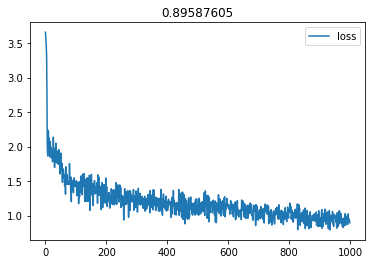

In [ ]:
MAX_LENGTH = 80
model.train()

for i in range(1000):
    batch_ix_ohe, batch_ix = to_matrix(sample(text2, 32), max_len=MAX_LENGTH)
    batch_ix_ohe = torch.LongTensor(batch_ix_ohe).float()
    batch_ix = torch.LongTensor(batch_ix)
    
    logp_seq, hid_state = model(batch_ix_ohe)
    
    loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))

    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.title(loss.data.numpy())
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [ ]:
model.eval()

def generate_sample(model, seed_phrase=' hallo', max_length=MAX_LENGTH, temperature=1.0):

  # x_sequence = [[idx_to_token[token] for token in seed_phrase]]
  # x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
  x_sequence_ohe, x_sequence = to_matrix([seed_phrase])
  x_sequence = torch.tensor(x_sequence, dtype=torch.int64)
  # print (x_sequence.shape)
  x_sequence_ohe = torch.LongTensor(x_sequence_ohe).float()
  hid_state = None
  
  #feed the seed phrase, if any
  for i in range(len(seed_phrase) - 1):
      _, hid_state = model.forward(x_sequence_ohe[:, i:i+1, :], hid_state)
  
  #start generating
  for _ in range(max_length - len(seed_phrase)):
      logp_next, hid_state = model.forward(x_sequence_ohe[:, -1:, :], hid_state)
      p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
      
      # sample next token and push it back into x_sequence
      next_ix = np.random.choice(num_tokens,p=p_next[0])
      next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
      next_ix_ohe = np.zeros(38)
      next_ix_ohe[next_ix.item()] = 1
      next_ix_ohe = next_ix_ohe.reshape(1,1,38)
      next_ix_ohe = torch.from_numpy(next_ix_ohe).float()
      # print (x_sequence.shape, next_ix.shape)
      x_sequence = torch.cat([x_sequence, next_ix], dim=1)
      # print (x_sequence_ohe.dtype, next_ix_ohe.dtype)
      x_sequence_ohe = torch.cat([x_sequence_ohe, next_ix_ohe], dim=1)
      
  return ''.join([tokens[ix] for ix in x_sequence[0].data.numpy()])

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
for _ in range(5):
  print(generate_sample(model, temperature=1))
print ('------------')
for _ in range(5):
  print(generate_sample(model, temperature=4))
print ('------------')
for _ in range(5):
  print(generate_sample(model, temperature=0.2))

 hallond once my the mo, anm flian ghacang'd
  in prind.
  u whale
  bretss,
  n
 hallove lave i optarses fuild;
  in shis tir,
  whave,
  o theen;
  yes bee tre
 hallons'lt the ssesreniny and thaben vich,
  rean,
  
                         
 hallost sinlonp's the theut dord slouk,
  lasid'd sheandon mosy
  boss ot bu,


 hallowfen blarelust lidy bourd,
  r houde, sas v nravin, wath mceag in;
  fam h
------------
 hallo!fukaun! wo
 whwurepmeqeba sns.-ogn;cm?.  as;
i a , ?  .:    f ,d j'c ss e
 hallons-e'st h!e
  gihjokcnzasondus,,vs; io tgryttoseu ctb,p-dik.b?t; os;!e    
 hallo!-, m cs-eafshi wtemw'm'bln.
- e t'm. s y!o  wilnhy?s,a luxw ptiq setemk.s
 halloes  :-kpdkchiobm-or sh wruwp.
': !m  ls  gj   
  e t  ,dnb ?jcmi-? j   
: 
 hallogrpnd brfa.gt  jitd ,xygyyg, (cectejd:bucfgwat,e: . )outuvt
d:co  q, y,rc 
------------
 hallong the the the the the she she she sreed,
  rereres,
  an thee the shee,
 
 hallong the the the me the the the she sreer,
  and thee the deed,
  and thee t
 h

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here
torch.save(model.state_dict(), 'text_model.pth')
model = MyModel()
model.load_state_dict(torch.load('text_model.pth'))
model.eval()

for _ in range(5):
  print(generate_sample(model, seed_phrase='what is ', temperature=0.5))


what is the the sodes houthed
  whteees theare.
  an thee to the,
  anreun.
  , 
what is she i the ire not thee;
  win beare,
  i lire,
  ne thee yer me.
  wheme
what is the wand ath salger.
   in the on hand;
  ne ghee sreet,
  becees,
  n t
what is she the she sremed poth;
  and an she
  chire,
  and fon thes,
  hiy lor
what is lirs the dor sreart,
  ne meetter gor;
  theeed;
   anee lore,
  be fat 


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)